##Density Matrix Renormalization Group

### Installing requirements for tenpy

In [ ]:
!git clone https://github.com/tenpy/tenpy.git

Cloning into 'tenpy'...
remote: Enumerating objects: 31909, done.
remote: Counting objects: 100% (1218/1218), done.
remote: Compressing objects: 100% (404/404), done.
remote: Total 31909 (delta 1001), reused 830 (delta 814), pack-reused 30691 (from 4)
Receiving objects: 100% (31909/31909), 14.13 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (25098/25098), done.


In [ ]:
%cd tenpy

/content/tenpy


In [ ]:
!pip install -e .

Obtaining file:///content/tenpy
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for physics-tenpy (pyproject.toml) ... done
  Created wheel for physics-tenpy: filename=physics_tenpy-1.0.6-0.editable-cp311-cp311-linux_x86_64.whl size=11388 sha256=b610116359afd017ecc8881098cb4a007e5e8db3659f21922a5f3979fa0f0c3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-7yu9du27/wheels/bd/85/a6/9b2733a9d2d26a605422357d23565058a3dd71aca54fbe1d9e
Successfully built physics-tenpy


In [ ]:
import tenpy
print(tenpy.__version__)


1.0.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Transverse Field Ising Model and DMRG in TeNPy

Here we describe implementation of the transverse field Ising model (TFIModel) using the Tensor Network Python library (TeNPy), focusing on its Hamiltonian structure, model parameters, DMRG algorithm settings, and the theoretical background based on the matrix product state (MPS) framework introduced in [Schollwöck (2011)](https://arxiv.org/abs/1008.3477).

---

#### Transverse Field Ising Model

The TFIM is defined on a lattice with the Hamiltonian consisting of nearest-neighbor spin interactions and a transverse magnetic field. The model captures the competition between ordering (due to spin-spin coupling) and quantum fluctuations (due to the transverse field).

#### Model Parameters

The model is specified via a configuration dictionary. The values in the example are selected for physical and numerical reasons:

- **`L = N`** – System size, defining the number of lattice sites. Typical choices range from 10 to 100 depending on available computational resources. Larger sizes approach the thermodynamic limit but increase computational cost.

- **`J = 1.0`** – The spin-spin coupling constant. Setting \( J = 1 \) is a standard normalization choice that allows comparison across different simulations. Other parameters (like `g`) are then interpreted relative to this unit.

- **`g = 1.0`** – The strength of the transverse magnetic field. The value \( g = 1 \) is particularly significant, as it represents the critical point of the 1D transverse field Ising model in the thermodynamic limit. At this value, the system undergoes a quantum phase transition from a ferromagnetic to a paramagnetic phase.

- **`bc_MPS = 'finite'`** – Boundary conditions applied to the MPS representation. 'Finite' implies open boundary conditions, suitable for systems of finite size. They are easier to handle numerically than periodic conditions.

---

#### DMRG Algorithm Parameters

TeNPy’s DMRG implementation is highly customizable. The parameters selected in the example balance precision, convergence reliability, and computational efficiency.

#### Algorithm Parameters

- **`mixer = True`** – Enables the use of a mixer, which introduces noise into the local optimization steps during early sweeps. This helps prevent the algorithm from getting stuck in local minima. It is gradually turned off, allowing fine convergence near the true ground state.

- **`max_E_err = 1e-10`** – Convergence threshold for the energy. The DMRG iterations stop when the energy changes between sweeps fall below this value. The choice of \(10^{-10}\) ensures highly accurate energy estimates suitable for precision studies, albeit with longer computation times.

- **`trunc_params`**:
  - **`chi_max = 1000`** – The maximum number of states (bond dimension) retained during truncation. A value of 1000 strikes a balance between accuracy and memory usage. Larger `chi_max` allows for more entanglement to be captured but increases computational cost.
  - **`svd_min = 1e-10`** – Minimum singular value threshold. Singular values smaller than this are discarded. This cutoff ensures numerical stability and avoids keeping noise-level components in the MPS.

- **`verbose = 1`** – Controls the level of output. A value of 1 provides moderate logging of DMRG progress without overwhelming detail, useful for monitoring convergence in typical simulations.

- **`N_sweeps_check = 2`** – The number of sweeps between convergence checks. Frequent checks help terminate the algorithm promptly when convergence is reached, saving computational time.

---

#### DMRG Implementation in TeNPy

TeNPy implements the Density Matrix Renormalization Group (DMRG) based on the modern formulation using Matrix Product States, as developed in [Schollwöck (2011)](https://arxiv.org/abs/1008.3477).

#### Key Features of the MPS-Based DMRG Algorithm

1. **Matrix Product States (MPS)**  
   Quantum many-body wavefunctions are approximated as a product of local tensors. This efficiently encodes entanglement for gapped 1D systems, leveraging the area law.

2. **Variational Optimization**  
   DMRG iteratively optimizes the MPS by minimizing the system's energy, sweeping back and forth over the chain. At each step, tensors are updated locally based on their effective Hamiltonian.

3. **Two-Site and One-Site Updates**  
   The algorithm typically begins with two-site updates to ensure robustness and transitions to faster one-site updates as convergence improves. The transition is guided by convergence metrics and the `mixer` mechanism.

4. **Truncation and SVD**  
   After optimization, tensors are decomposed using Singular Value Decomposition. The MPS is truncated to retain only the most significant singular values (based on `chi_max` and `svd_min`) to control the growth of computational complexity.

5. **Convergence and Stopping Criteria**  
   Energy convergence is monitored based on `max_E_err` and checked every `N_sweeps_check` sweeps. Once changes in energy become negligible, the algorithm halts, yielding the ground-state MPS.

---

## References

- Schollwöck, U. (2011). *The density-matrix renormalization group in the age of matrix product states*. [arXiv:1008.3477](https://arxiv.org/abs/1008.3477)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import json
from dmrg_model import DMRG


mpl.rcParams.update({'font.size':30})
mpl.rcParams.update({'lines.linewidth':2})

In [ ]:
# Parameters
min_size = int(input('Minimun numder of spins: '))
max_size = int(input('Maximum numder of spins: '))

J = 1.0
g = 1.0
boundary = "finite"

In [ ]:
results = []
for L in range(min_size, max_size + 1, 10):

    print(f"--- Running L = {L} ---")
    model = DMRG(size=L, J=J, g=g, bound=boundary)

    # Exact diagonalization
    start_exact = time.time()
    E_exact = model.finite_gs_energy(L=L, J=J, g=g)
    time_exact = time.time() - start_exact if not np.isnan(E_exact) else np.nan

    # DMRG
    try:
        info, time_dmrg, _ = model.run_dmrg()
        E_dmrg = info['E']
    except Exception as e:
        E_dmrg = np.nan
        time_dmrg = np.nan
        print(f"DMRG failed at L={L}: {e}")

    results.append({
        "L": L,
        "E_exact": E_exact,
        "E_dmrg": E_dmrg,
        "time_exact": time_exact,
        "time_dmrg": time_dmrg,
        "abs_error": abs(E_exact - E_dmrg) if not np.isnan(E_exact) and not np.isnan(E_dmrg) else np.nan
    })

# Save results
df = pd.DataFrame(results)
df.to_csv("dmrg_vs_exact_res.csv", index=False)
print("Finished! Results saved to dmrg_vs_exact_res.csv")

--- Running L = 2 ---
DMRG failed at L=2: 
--- Running L = 12 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused options for config DMRG:
['max_E_err', 'verbose']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused options for config trunc_params:
['chi_max', 'svd_min']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 22 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 32 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 42 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 52 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 62 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 72 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 82 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/content/dmrg_model.py:67: UserWarning: Exact diagonalization skipped for L > 20.
  if L > 20:


--- Running L = 92 ---
Finished! Results saved to dmrg_vs_exact_res.csv


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [ ]:
df_small = pd.read_csv("dmrg_vs_exact_res_2_20_1.csv")
df_big = pd.read_csv("dmrg_vs_exact_res_2_100_10.csv")

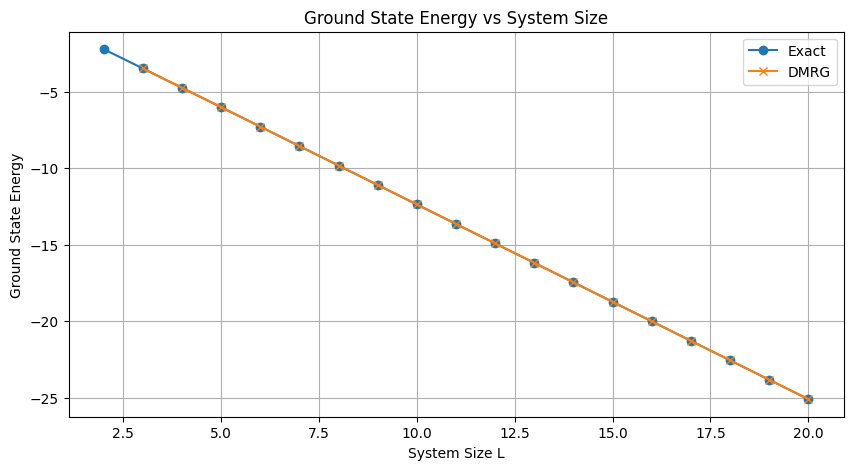

In [ ]:
# Plot energies
plt.figure(figsize=(10, 5))
plt.plot(df_small["L"], df_small["E_exact"], label="Exact", marker='o')
plt.plot(df_small["L"], df_small["E_dmrg"], label="DMRG", marker='x')
#plt.yscale("log")
plt.xlabel("System Size L")
plt.ylabel("Ground State Energy")
plt.title("Ground State Energy vs System Size")
plt.legend()
plt.grid(True)
plt.show()

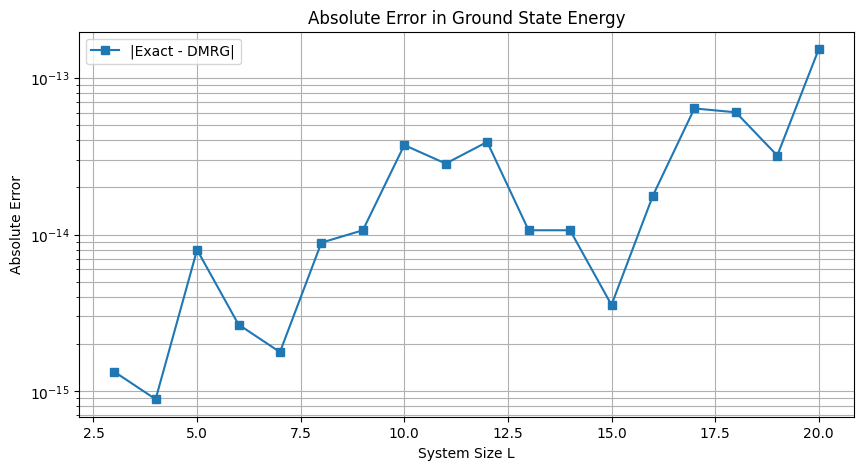

In [ ]:
# Plot absolute error (log scale)
plt.figure(figsize=(10, 5))
plt.plot(df_small["L"], df_small["abs_error"], label="|Exact - DMRG|", marker='s')
plt.yscale("log")
plt.xlabel("System Size L")
plt.ylabel("Absolute Error")
plt.title("Absolute Error in Ground State Energy")
plt.legend()
plt.grid(True, which="both")
plt.show()

In [ ]:
with open('nnqs_times.json', 'r') as file:
    nnqs_times = json.load(file)
    nnqs_N_arr = [int(i) for i in list(nnqs_times.keys())]
    nnqs_times_arr = list(nnqs_times.values())
with open('nnqs1_times.json', 'r') as file:
    nnqs1_times = json.load(file)
    nnqs1_N_arr = [int(i) for i in list(nnqs1_times.keys())]
    nnqs1_times_arr = list(nnqs1_times.values())
with open('nnqs1symm_times.json', 'r') as file:
    nnqs1_times = json.load(file)
    nnqs1symm_N_arr = [int(i) for i in list(nnqs1_times.keys())]
    nnqs1symm_times_arr = list(nnqs1_times.values())

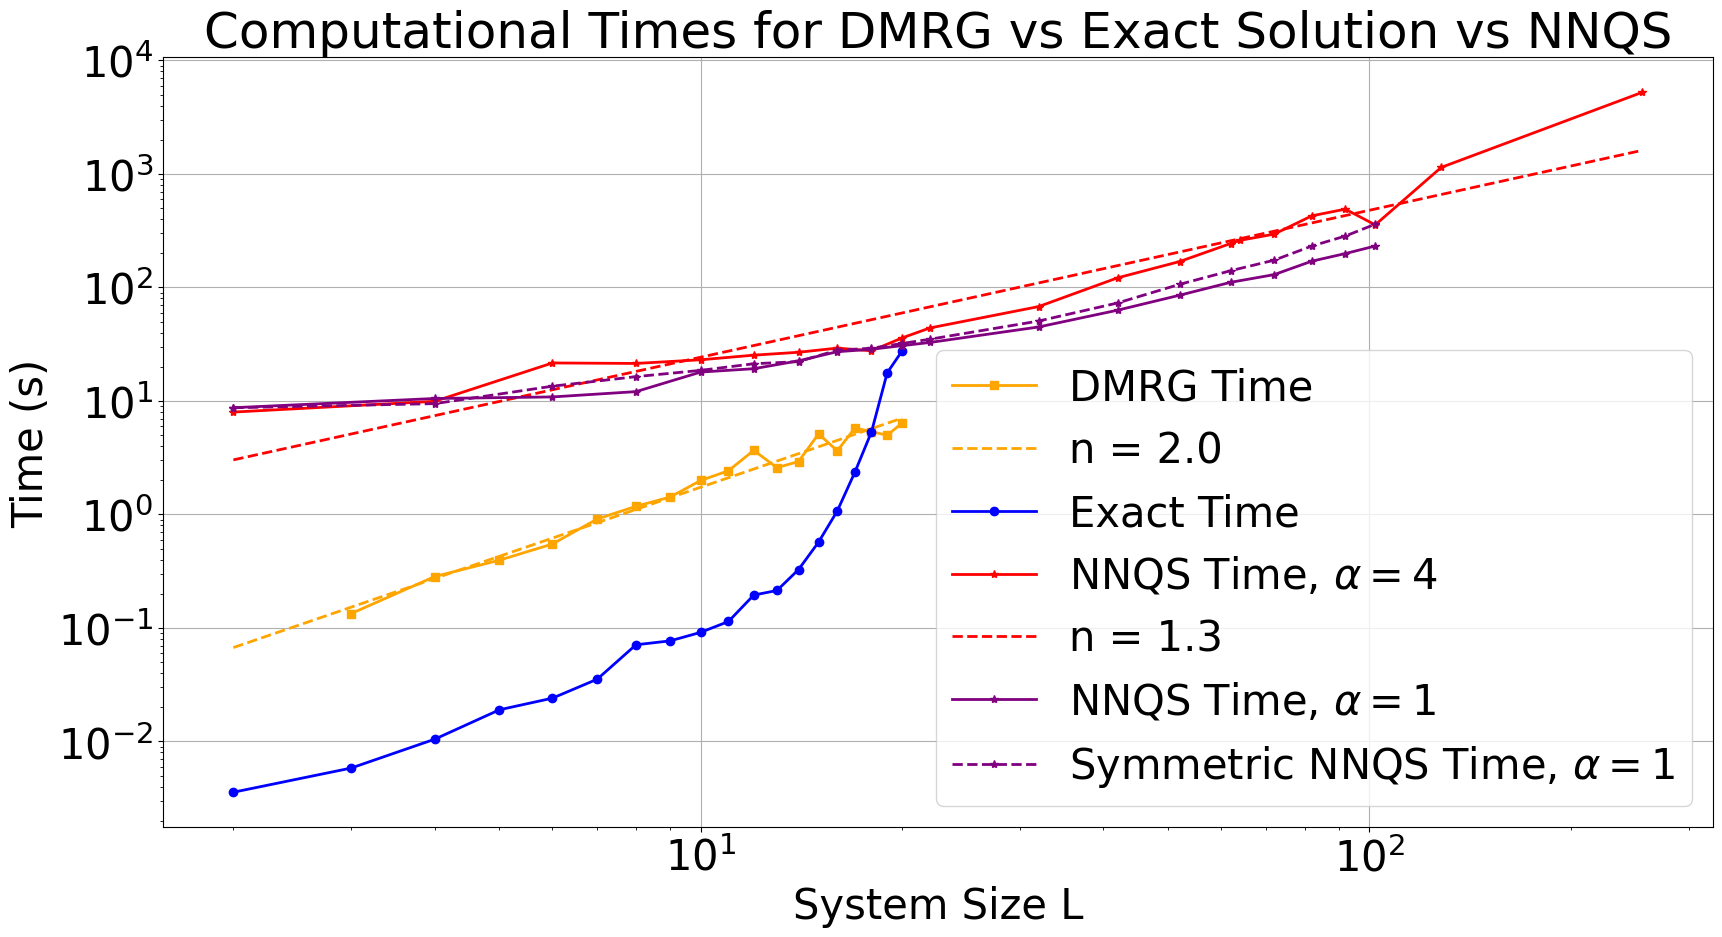

In [ ]:
# Plot time
plt.figure(figsize=(20, 10))
plt.plot(df_small["L"], df_small["time_dmrg"], label="DMRG", marker='s', color = 'orange')
a, b = np.polyfit(np.log(df_small["L"][1:]), np.log(df_small["time_dmrg"][1:]), 1)
plt.plot(df_small["L"], np.exp(a*np.log(df_small["L"])+b), color = 'orange', linestyle='dashed', label = f'n = {round(a, 1)}')

plt.plot(df_small["L"], df_small["time_exact"], label="Exact", marker='o', color = 'blue')
plt.plot(nnqs_N_arr, nnqs_times_arr, label= r"NNQS, $\alpha=4$", marker='*', color = 'red')
a, b = np.polyfit(np.log(nnqs_N_arr), np.log(nnqs_times_arr), 1)
plt.plot(nnqs_N_arr, np.exp(a*np.log(nnqs_N_arr)+b), color = 'red', linestyle='dashed', label = f'n = {round(a, 1)}')

plt.plot(nnqs1_N_arr, nnqs1_times_arr, label= r"NNQS, $\alpha=1$", marker='*', color = 'purple', linestyle='solid')
plt.plot(nnqs1_N_arr, nnqs1symm_times_arr, label= r"Symmetric NNQS, $\alpha=1$", marker='*', color = 'purple', linestyle='dashed')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("System Size L")
plt.ylabel("Time (s)")
plt.title("Computational Times for DMRG vs Exact Solution vs NNQS")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Redefine properties

g_values = np.linspace(0.1, 2.0, 30)  # Range for transverse field g
size = 20                             # Fixed system size
J = 1.0                               # Coupling constant
boundary = 'finite'                   # Boundary conditions

In [ ]:
# Here we store results
results = []
magnetizations_z = []
entanglement_entropy = []

# In this case we vary trasverse field to verify the model
for g in g_values:
    print(f"--- Running g = {g} ---")
    model = DMRG(size=size, J=J, g=g, bound=boundary)

    try:
        info, time_dmrg, psi = model.run_dmrg()
        E_dmrg = info['E']

        sz_expect = psi.expectation_value('Sigmaz')
        magnetization = np.mean(sz_expect)

        entropy = psi.entanglement_entropy()
        if isinstance(entropy, np.ndarray):
            entropy = np.max(entropy)

    except Exception as e:
        print(f"DMRG failed at g={g}: {e}")
        E_dmrg = np.nan
        time_dmrg = np.nan
        magnetization = np.nan
        entropy = np.nan

    magnetizations_z.append(magnetization)
    entanglement_entropy.append(entropy)

    results.append({
        "g": g,
        "E_dmrg": E_dmrg,
        "time_dmrg": time_dmrg,
        "magnetization_z": magnetization,
        "entropy": entropy
    })


# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("dmrg_properties_2.csv", index=False)
print("Finished! Results saved to dmrg_properties_2.csv")

--- Running g = 0.1 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.16551724137931034 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.23103448275862068 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.296551724137931 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.3620689655172413 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.4275862068965517 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.49310344827586206 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.5586206896551723 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.6241379310344827 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.689655172413793 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.7551724137931034 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.8206896551724137 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.886206896551724 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 0.9517241379310344 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.0172413793103448 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.0827586206896551 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.1482758620689655 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.2137931034482758 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.2793103448275862 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.3448275862068966 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.410344827586207 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.475862068965517 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.5413793103448274 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.6068965517241378 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.6724137931034482 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.7379310344827585 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.803448275862069 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.8689655172413793 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 1.9344827586206894 ---


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


--- Running g = 2.0 ---
Finished! Results saved to dmrg_properties_2.csv


/content/tenpy/tenpy/tools/params.py:232: UserWarning: unused option ['verbose'] for config DMRG
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [ ]:
df_prop = pd.read_csv("dmrg_properties.csv")

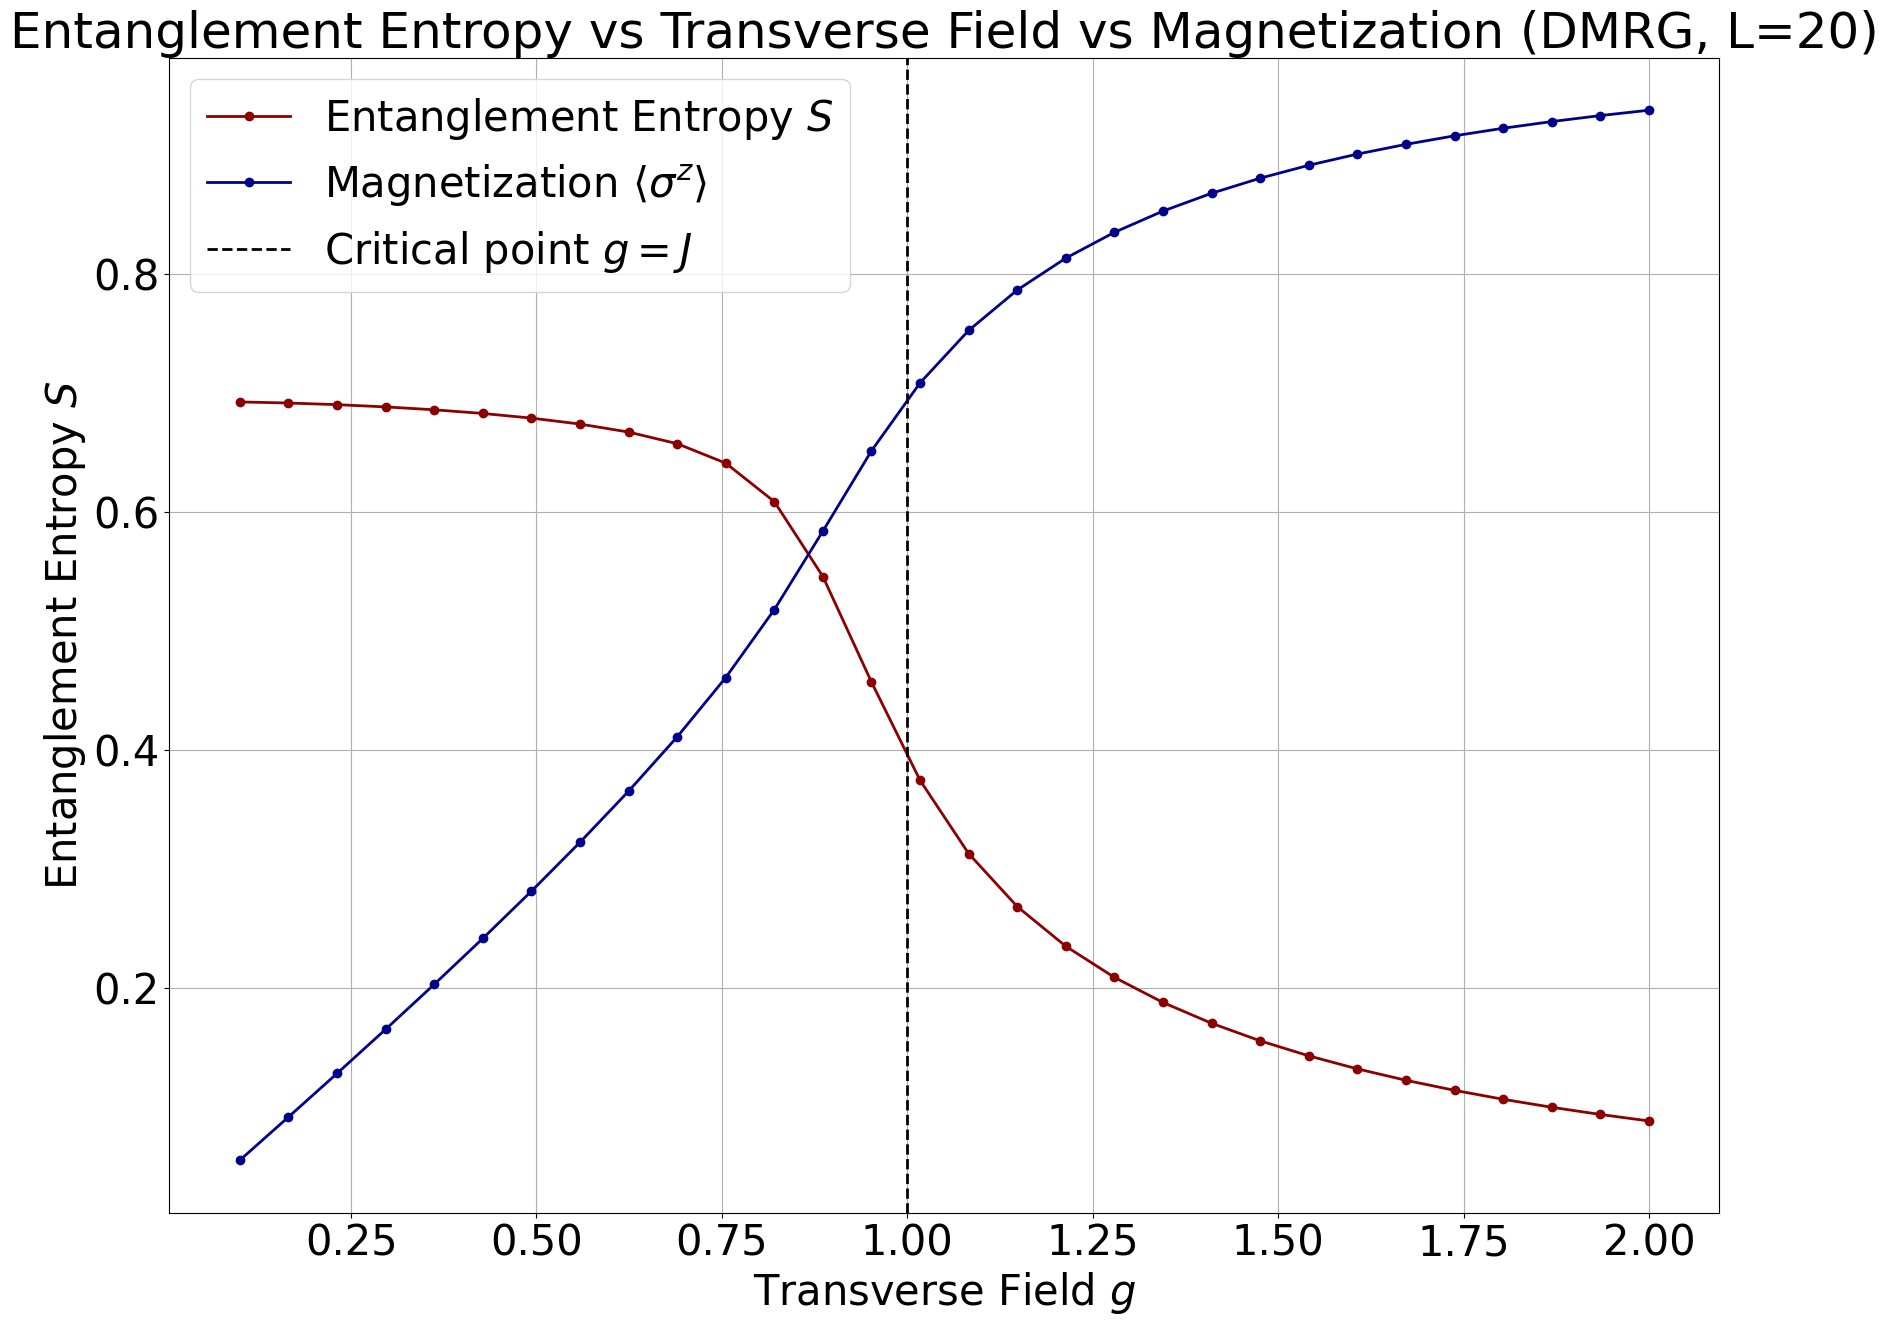

In [ ]:
# Plotting: Magnetization ⟨σ^z⟩ vs g
"""
plt.figure(figsize=(20, 15))
plt.plot(df_prop['g'], df_prop['magnetization_z'], marker='o', label=r'Magnetization $\langle \sigma^z \rangle$', color='darkblue')
plt.axvline(x=J, color='black', linestyle='--', label='Critical point $g=J$')
plt.xlabel('Transverse Field $g$')
plt.ylabel(r'Magnetization $\langle \sigma^z \rangle$')
plt.title(f'Magnetization vs Transverse Field (DMRG, L={size})')
plt.grid(True)
plt.legend()
#plt.tight_layout()
#plt.show()
"""

# Plotting: Entanglement Entropy vs g
plt.figure(figsize=(20, 15))
plt.plot(df_prop['g'], df_prop['entropy'], marker='o', label=r'Entanglement Entropy $S$', color='darkred')
plt.plot(df_prop['g'], df_prop['magnetization_z'], marker='o', label=r'Magnetization $\langle \sigma^z \rangle$', color='darkblue')
plt.axvline(x=J, color='black', linestyle='--', label='Critical point $g=J$')
plt.xlabel('Transverse Field $g$')
plt.ylabel('Entanglement Entropy $S$')
plt.title(f'Entanglement Entropy vs Transverse Field vs Magnetization (DMRG, L={size})')
plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.show()


In [ ]:
#Petya's area
nnqs_N_arr = np.unique(np.array( list(range(2, 23, 2)) + list(range(2,103,10)) + [64, 128, 256]))
nnqs_gs_arr = []
nnqs4_gs_arr = []
nnqs1symm_gs_arr = []
for N in nnqs_N_arr:
    try: #alpha = 1
        with open(f'log_{N}.json') as json_data:
            data_FFN = json.load(json_data)
            nnqs_gs_arr.append(data_FFN["Energy"]['Mean'][-1])
    except OSError:
        nnqs_gs_arr.append(None)
        pass

    try: #alpha = 4
        with open(f'log_{N}_4.json') as json_data:
            data_FFN = json.load(json_data)
            nnqs4_gs_arr.append(data_FFN["Energy"]['Mean'][-1])
    except OSError:
        nnqs4_gs_arr.append(None)
        pass

    try: #alpha = 1, symmetric NNQS
        with open(f'log_{N}_1_symm.json') as json_data:
            data_FFN = json.load(json_data)
            nnqs1symm_gs_arr.append(data_FFN["Energy"]['Mean'][-1])
    except OSError:
        nnqs1symm_gs_arr.append(None)
        pass

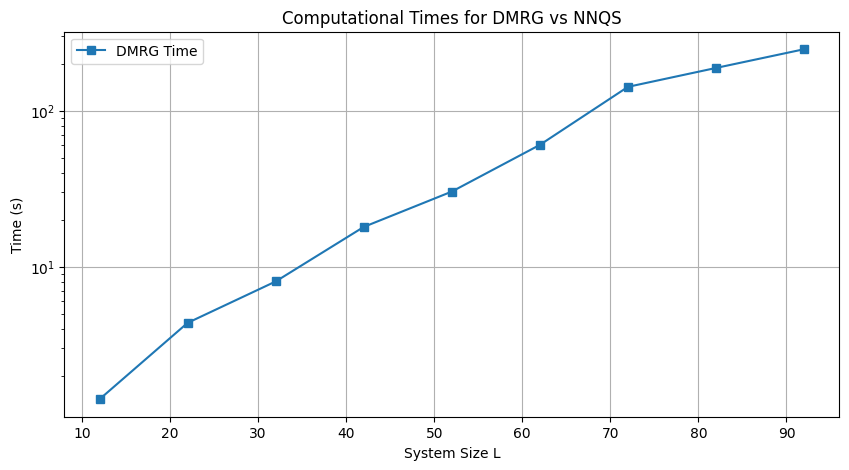

In [ ]:
# Plot time
plt.figure(figsize=(10, 5))
plt.plot(df_big["L"], df_big["time_dmrg"], label="DMRG Time", marker='s')
"""
ПЕТЯ!!!!
"""
#plt.plot(nnqs_N_arr, ???, label="NNQG Time", marker='o')
plt.yscale("log")
plt.xlabel("System Size L")
plt.ylabel("Time (s)")
plt.title("Computational Times for DMRG vs NNQS")
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0.93, 'Ground State Energy vs System Size')

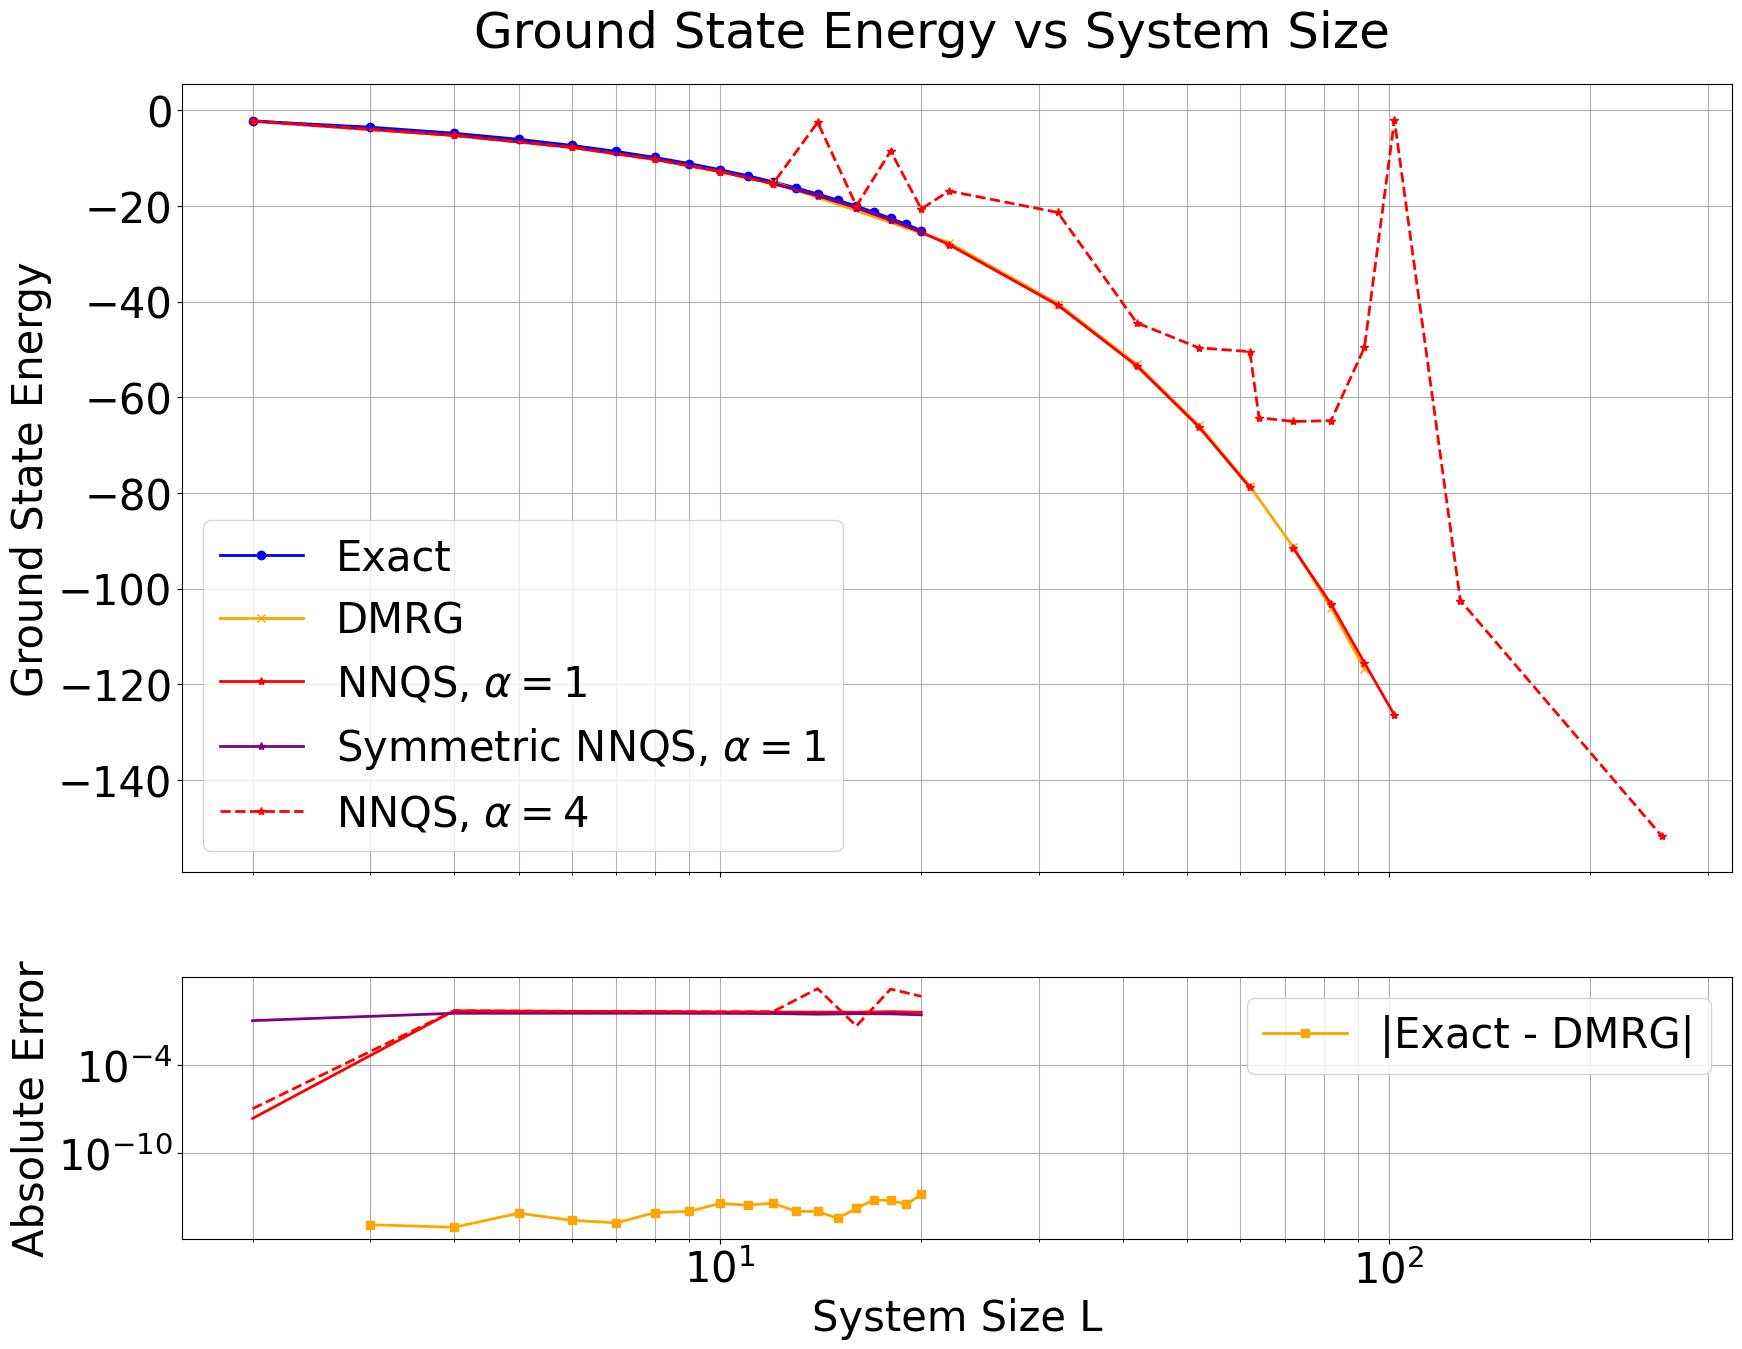

In [ ]:
# Plot energies
fig, ax = plt.subplots(2,1,figsize = (20, 15), sharex=True, gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(df_small["L"], df_small["E_exact"], label="Exact", marker='o', color = 'blue')
ax[0].plot(df_big["L"], df_big["E_dmrg"], label="DMRG", marker='x', color = 'orange')

ax[0].plot(nnqs_N_arr, nnqs_gs_arr, label = r'NNQS, $\alpha=1$', color = 'red', marker = '*')
ax[0].plot(nnqs_N_arr, nnqs1symm_gs_arr, label = r'Symmetric NNQS, $\alpha=1$', color = 'purple', marker = '*', linestyle='solid')
ax[0].plot(nnqs_N_arr, nnqs4_gs_arr, label = r'NNQS, $\alpha=4$', color = 'red', linestyle = 'dashed', marker = '*')

ax[0].set_xscale("log")
ax[0].set_ylabel("Ground State Energy")

ax[1].plot(df_small["L"], df_small["abs_error"], label="|Exact - DMRG|", marker='s', color = 'orange')
for cur_nnqs, linestyle, color in zip([nnqs_gs_arr, nnqs1symm_gs_arr, nnqs4_gs_arr]
                                ,['solid', 'solid', 'dashed']
                                ,['red', 'purple', 'red']):
    nn_in_ex, ex_in_nn = np.intersect1d(df_small['L'], nnqs_N_arr, return_indices=True)[1:]
    exact_gs_intersect = df_small['E_exact'][nn_in_ex]
    nnqs_gs_intersect = np.array(cur_nnqs)[ex_in_nn]
    differences = exact_gs_intersect - nnqs_gs_intersect
    intersect_N_arr = df_small["L"][nn_in_ex]
    ax[1].plot(intersect_N_arr, np.abs(differences), color = color, linestyle=linestyle)

ax[1].set_ylabel('Absolute Error')
ax[1].set_yscale('log')
ax[1].set_xlabel("System Size L")

for a in ax:
    a.grid(which = 'both')
    a.legend()
fig.suptitle("Ground State Energy vs System Size", y = 0.93)

# Energy as function of g

In [ ]:
nnqs1symm_gs_l_arr = []
nnqs1_gs_l_arr = []
exact_gs_l_arr = []
for g in g_values:
    with open(f'log_102_1_l_{g}_symm.json', 'r') as file:
        data_FFN = json.load(file)
        nnqs1symm_gs_l_arr.append(data_FFN["Energy"]['Mean'][-1])
    with open(f'log_102_1_l_{g}.json', 'r') as file:
        data_FFN = json.load(file)
        nnqs1_gs_l_arr.append(data_FFN["Energy"]['Mean'][-1])
with open(f'exact_gs_l.json', 'r') as file:
    data = json.load(file)
    for g in g_values:
        exact_gs_l_arr.append(data[str(g)])

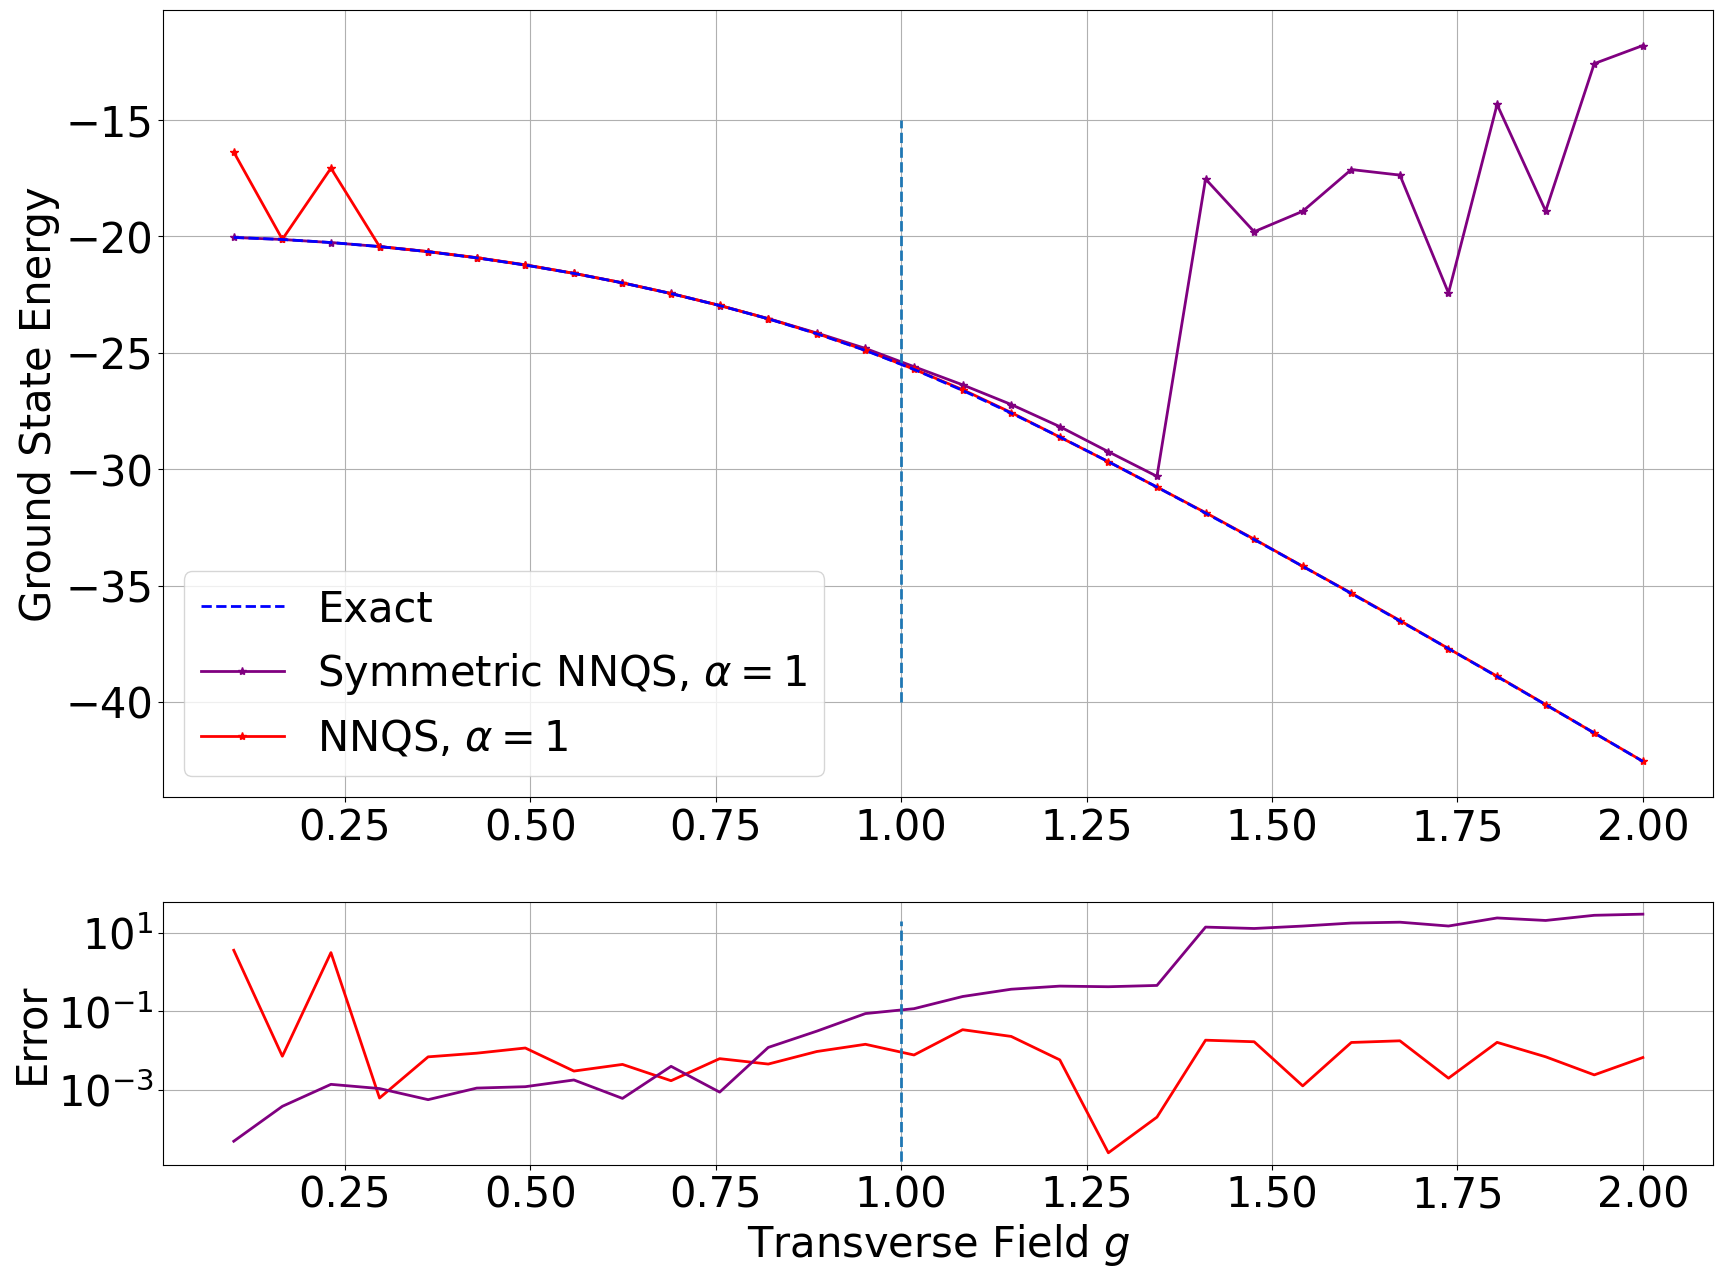

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (20, 15), gridspec_kw={'height_ratios':[3,1]})
ax[0].plot(g_values, exact_gs_l_arr, label = 'Exact', color = 'blue', linestyle = 'dashed',zorder=3)
ax[0].plot(g_values, nnqs1symm_gs_l_arr, label = r'Symmetric NNQS, $\alpha=1$', color = 'purple', marker = '*')
ax[0].plot(g_values, nnqs1_gs_l_arr, label = r'NNQS, $\alpha=1$', color = 'red', marker = '*')
ax[0].set_ylabel('Ground State Energy')
ax[0].vlines(1, -40, -15, linestyle='dashed')
ax[0].legend()

ax[1].plot(g_values, np.abs(np.array(exact_gs_l_arr) - np.array(nnqs1_gs_l_arr)), label = r'|NNQS-Exact|', color='red')
ax[1].plot(g_values, np.abs(np.array(exact_gs_l_arr) - np.array(nnqs1symm_gs_l_arr)), label = r'|Symm-Exact|', color='purple')
ax[1].set_xlabel('Transverse Field $g$')
ax[1].set_yscale('log')
ax[1].set_ylabel('Error')
ax[1].vlines(1, 0, 20, linestyle='dashed')
for a in ax:
    a.grid()

Text(0.5, 1.0, 'g = 1.8')

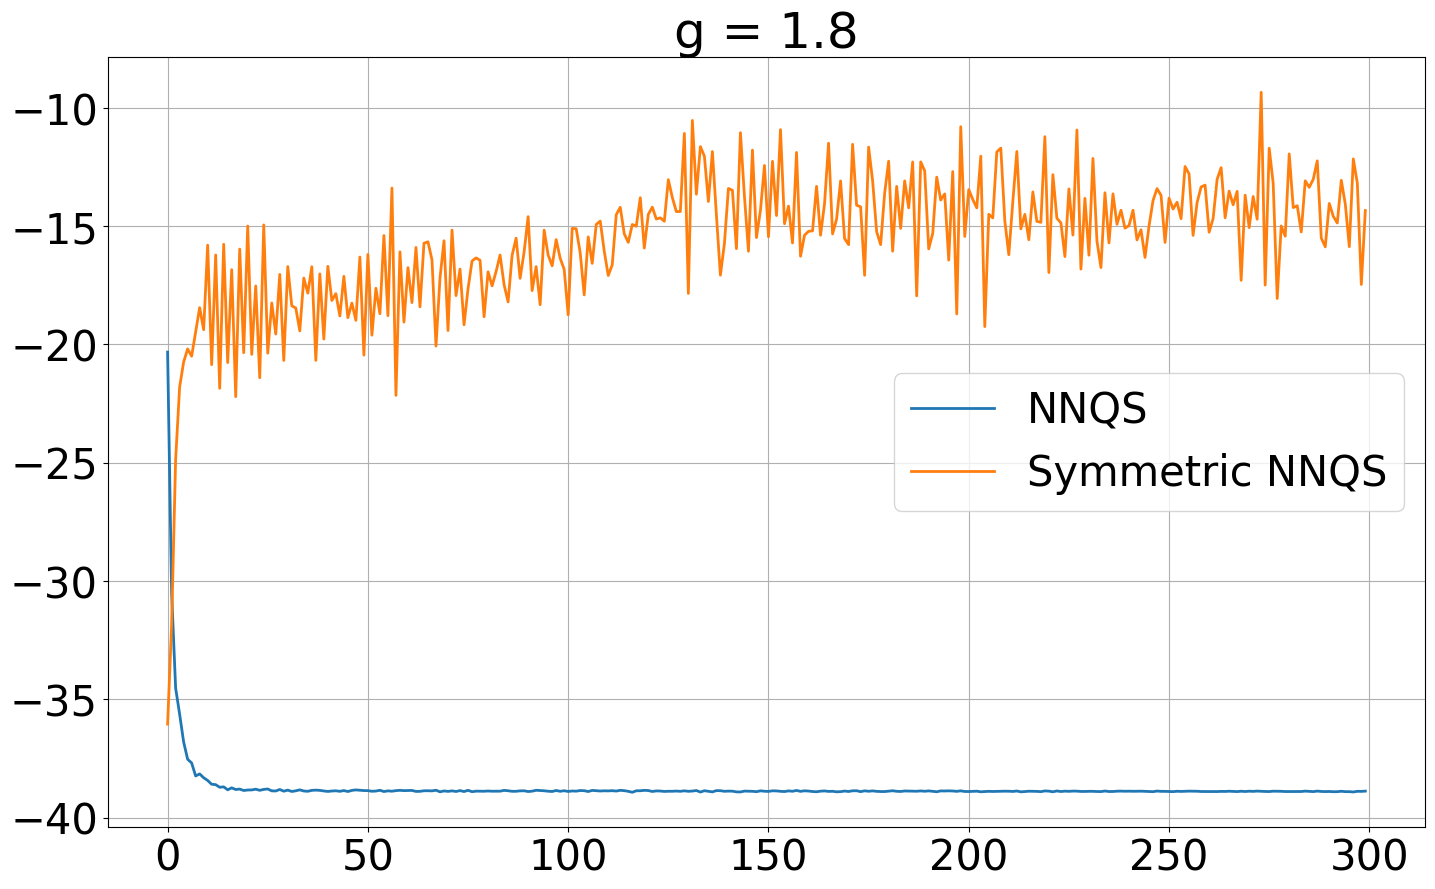

In [ ]:
#some log exaples
i = -4

plt.figure(figsize = (17, 10))
with open(f'log_102_1_l_{g_values[i]}.json', 'r') as file:
    data_FFN = json.load(file)
    plt.plot(data_FFN['Energy']['Mean'], label = 'NNQS')

with open(f'log_102_1_l_{g_values[i]}_symm.json', 'r') as file:
    data_FFN = json.load(file)
    plt.plot(data_FFN['Energy']['Mean'], label = 'Symmetric NNQS')
plt.legend()
plt.grid()
plt.title(f'g = {round(g_values[i], 2)}')

### Single-site infinite DMRG, transverse field Ising model


In [ ]:
# iDMRG parameters
idmrg_params = {
    'mixer': True,            # to avoid that the algorithm gets stuck in local energy minima
    'max_E_err': 1e-10,
    'trunc_params': {
        'chi_max': 30,
        'svd_min': 1e-10,
    },
    'verbose': 1,
    'N_sweeps_check': 2,
}

model_params = dict(L=2, # MUST for iDMRG using TeNPy
                    J=1.,
                    g=1.,
                    bc_MPS='infinite',
                    conserve=None)

M = TFIChain(model_params)

product_state = ["up"] * M.lat.N_sites

psi = MPS.from_product_state(M.lat.mps_sites(), product_state, bc=M.lat.bc_MPS)

eng = dmrg.SingleSiteDMRGEngine(psi, M, idmrg_params)
E, psi = eng.run()  # equivalent to dmrg.run() up to the return parameters.

print("E = {E:.13f}".format(E=E))
print("final bond dimensions: ", psi.chi)

mag_x = np.mean(psi.expectation_value("Sigmax"))
mag_z = np.mean(psi.expectation_value("Sigmaz"))

print("<sigma_x> = {mag_x:.5f}".format(mag_x=mag_x))
print("<sigma_z> = {mag_z:.5f}".format(mag_z=mag_z))
print("correlation length:", psi.correlation_length())

# compare to exact result
E_exact = infinite_gs_energy(1., 1.)
print("Analytic result: E (per site) = {E:.13f}".format(E=E_exact))
print("relative error: ", abs((E - E_exact) / E_exact))

E = -1.9099013180437
final bond dimensions:  [30, 30]
<sigma_x> = -0.29321
<sigma_z> = 0.63662
correlation length: 790.001203244766
Analytic result: E (per site) = -1.2732395447352
relative error:  0.5000329874618831
